# 1. Setup and Load Data

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import img_to_array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from zipfile import ZipFile 

from skimage import io
import os
import cv2
from skimage import io

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import random
import re
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
cpu = tf.config.experimental.list_physical_devices('GPU')

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
path_zip_file="technical_challenge_data.zip"

with ZipFile(path_zip_file, 'r') as zipp: 
    # printing all the contents of the zip file 
    zipp.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zipp.extractall() 
    print('Done!') 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Done!


In [23]:
list_sample_names=[]

for filename in os.listdir("technical_challenge_data/modality1/"):
    if filename.endswith(".png"): 
        list_sample_names.append(filename)
    else:
        continue

In [24]:
df=pd.DataFrame()

df['Sample']=list_sample_names
df['ToothID']=df['Sample'].str.findall(r'(\d+(?:\.\d+)?)').str[1].astype(int)
df['target']=0
df.loc[df['ToothID'].isin(list(range(6,12)))|df['ToothID'].isin(list(range(22,28))),'target']=1

In [25]:
print("Anterior Teeth Ratio: ", round(df[df['target']==1].shape[0]/df.shape[0], 4))

Anterior Teeth Ratio:  0.269


In [26]:
X=df.loc[:, df.columns != 'target']
y=df['target']

In [27]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=42)

In [28]:
s=0
for filename in list_sample_names:
    list_numbers=[int(s) for s in re.findall(r'[\d]+', filename)]
    toothID=list_numbers[1]
    target=(toothID in range(6,12))|(toothID in range(22,28))
    s+=target
print(s) #a number of Anterior Teeth

9342


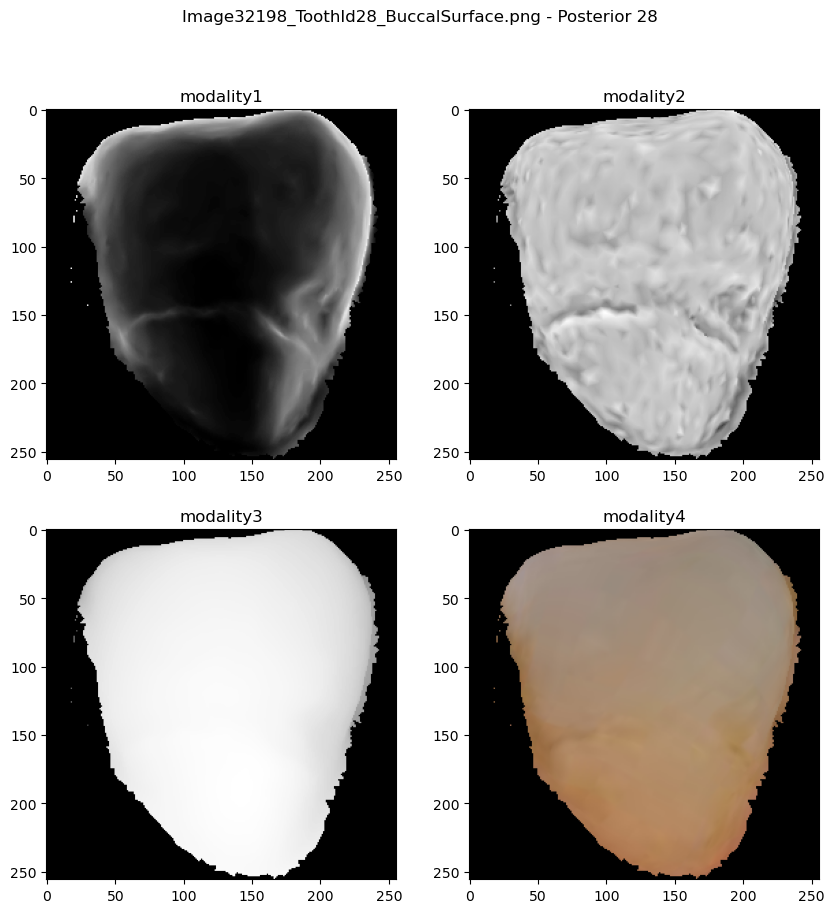

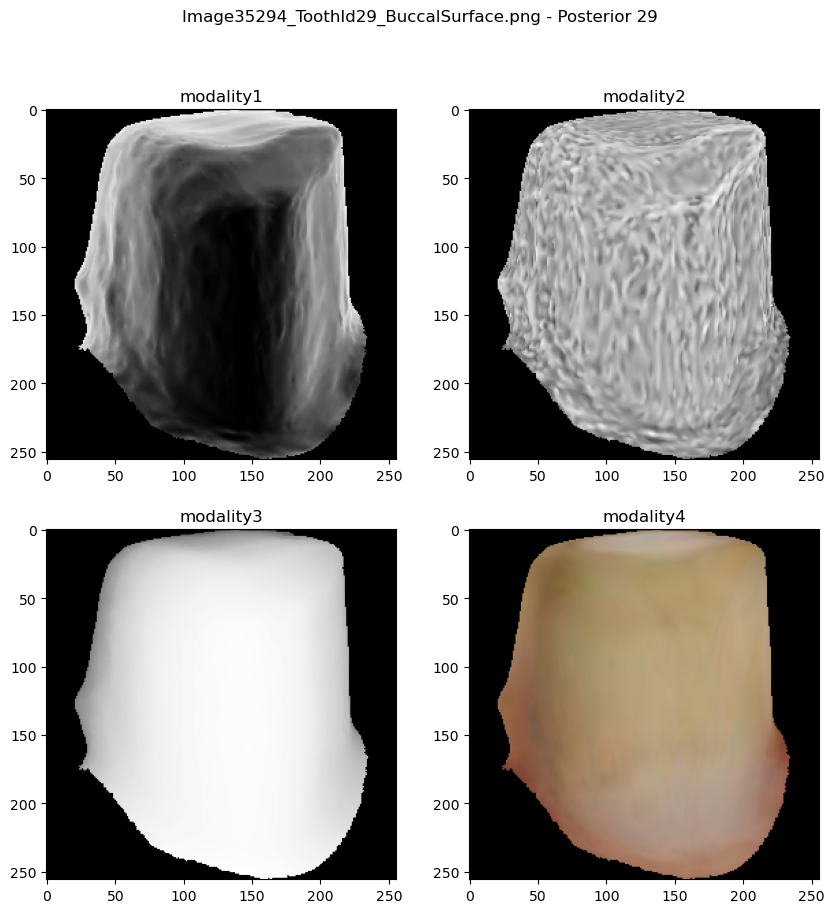

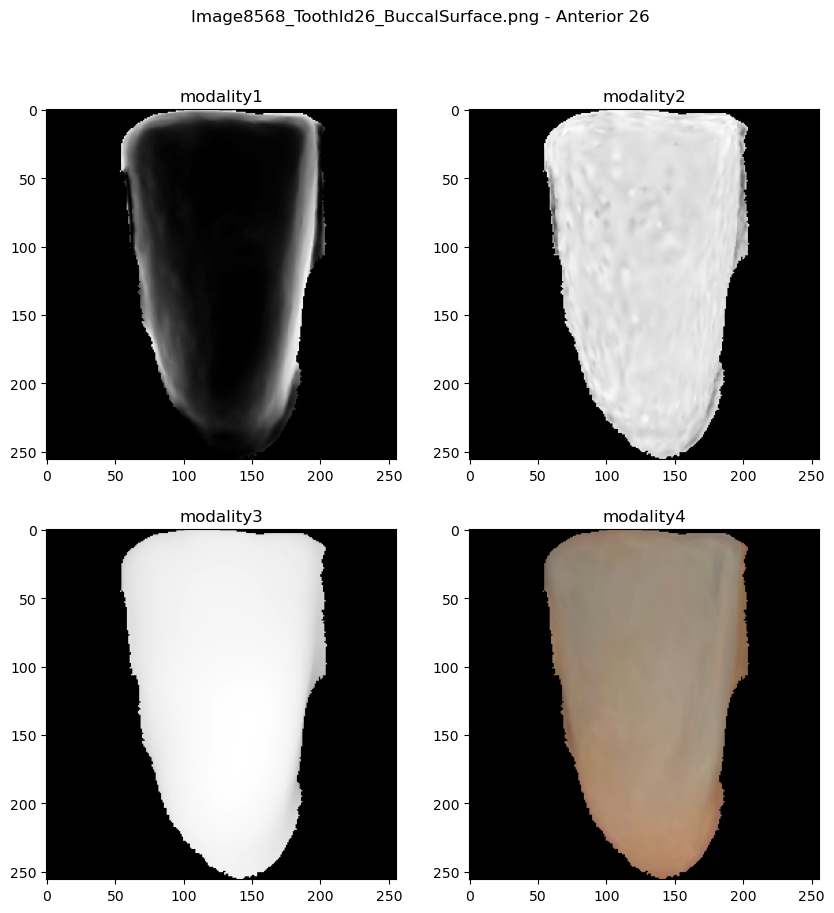

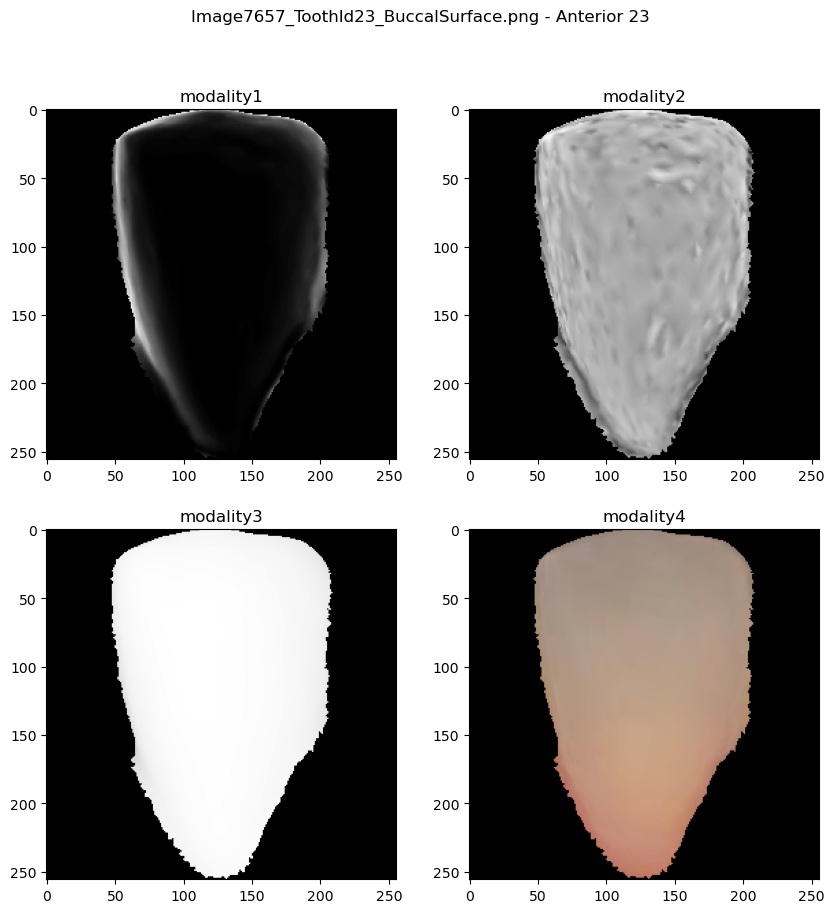

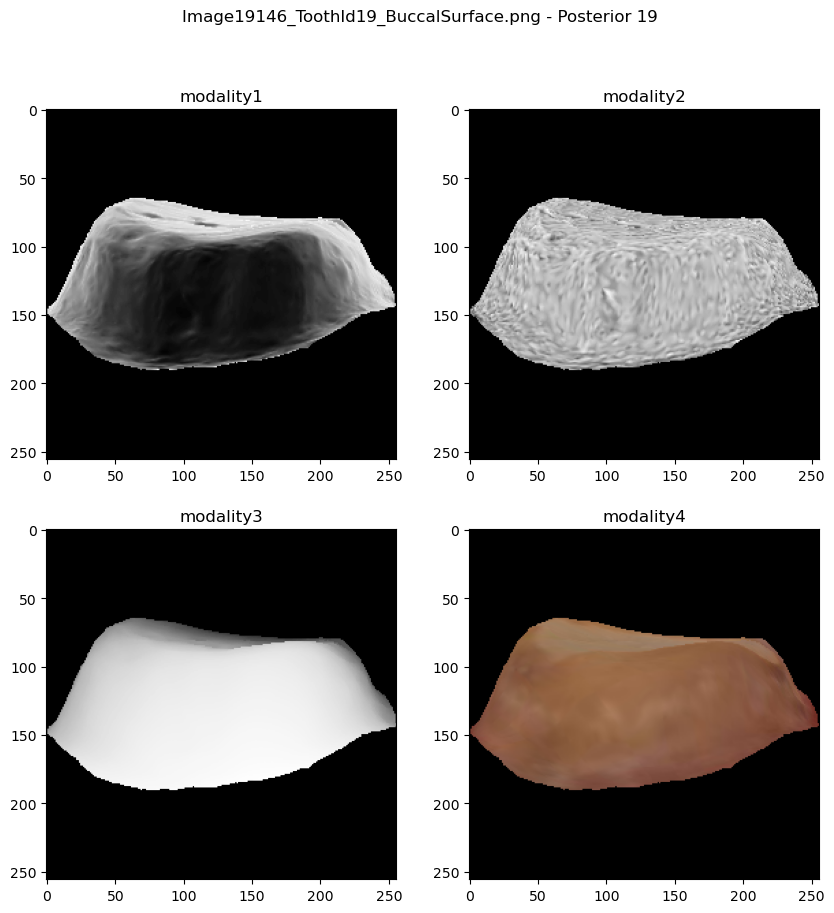

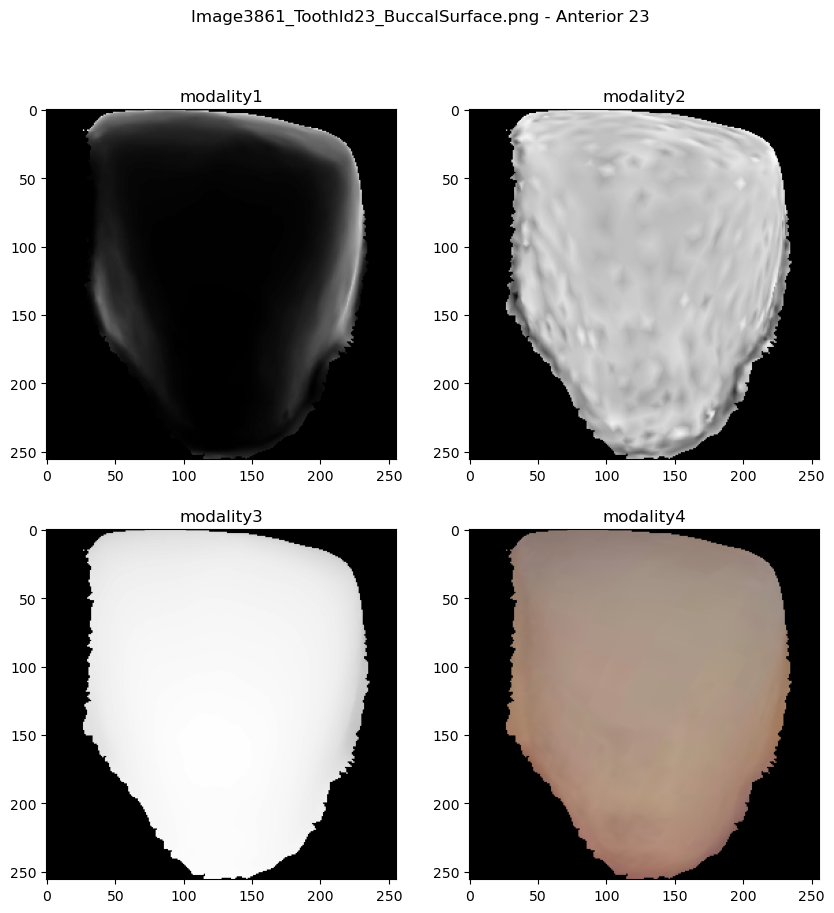

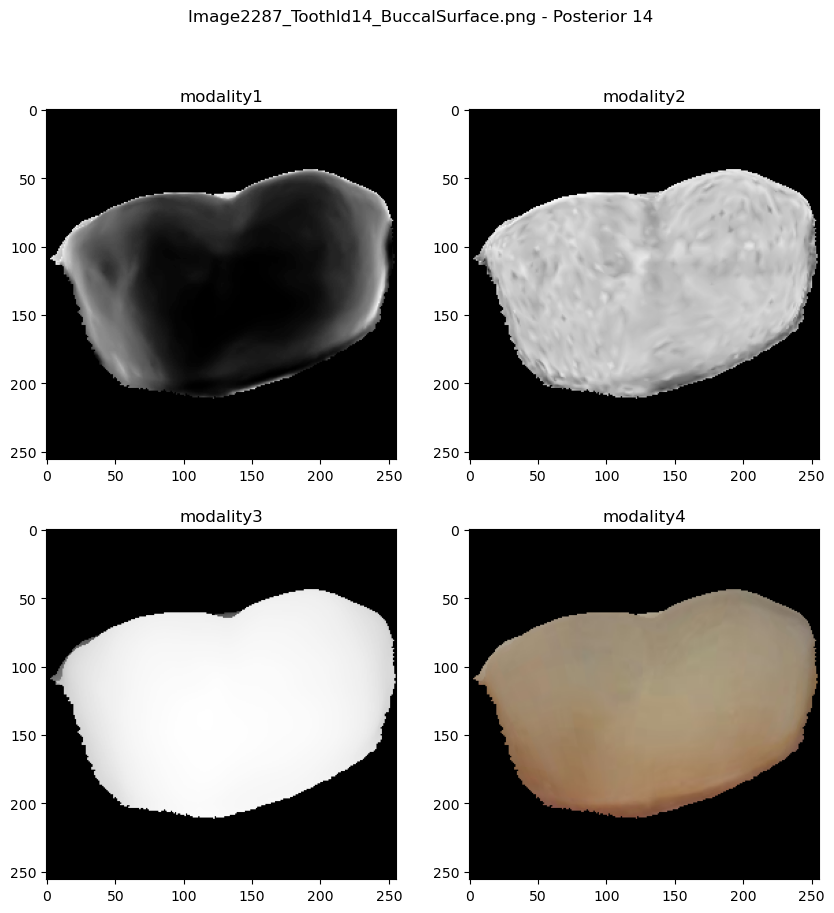

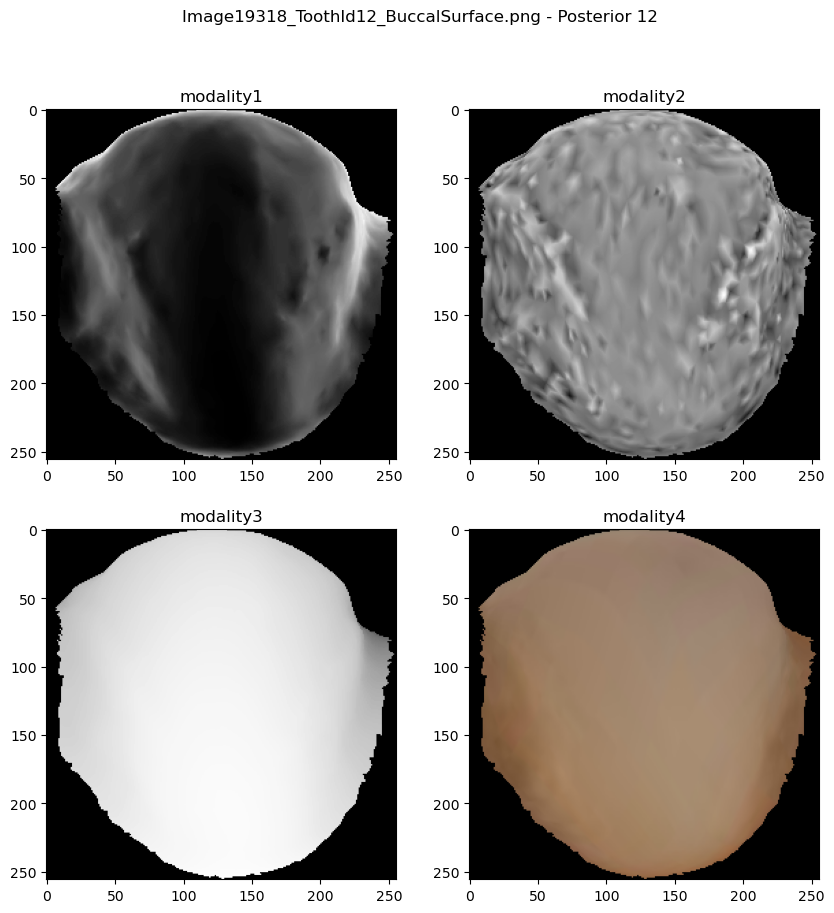

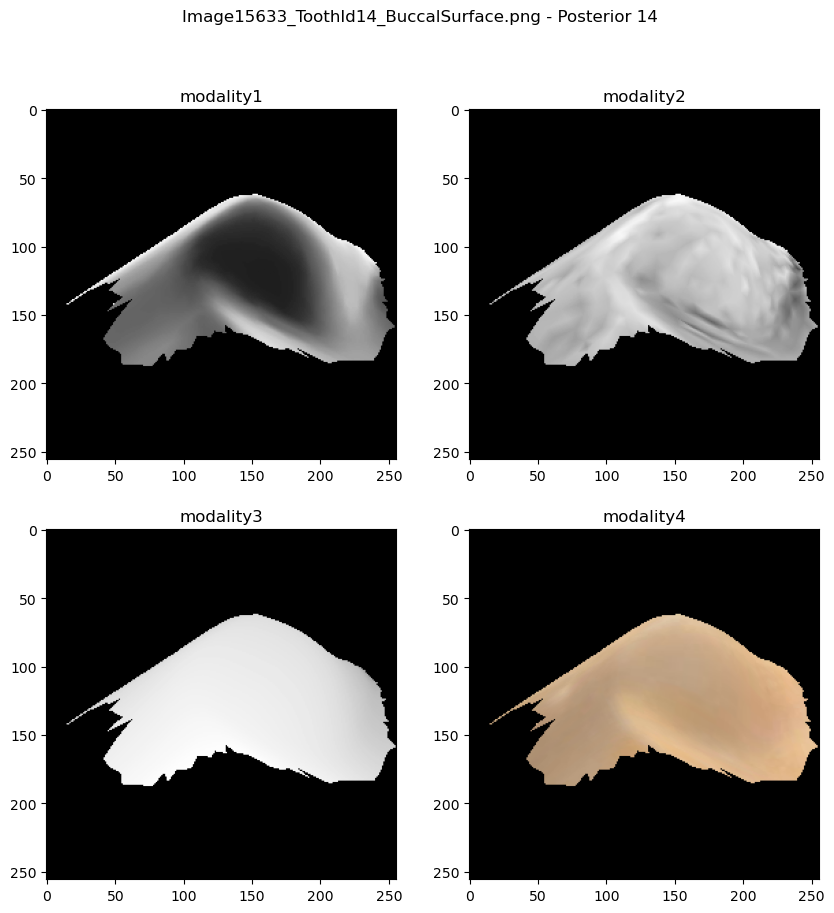

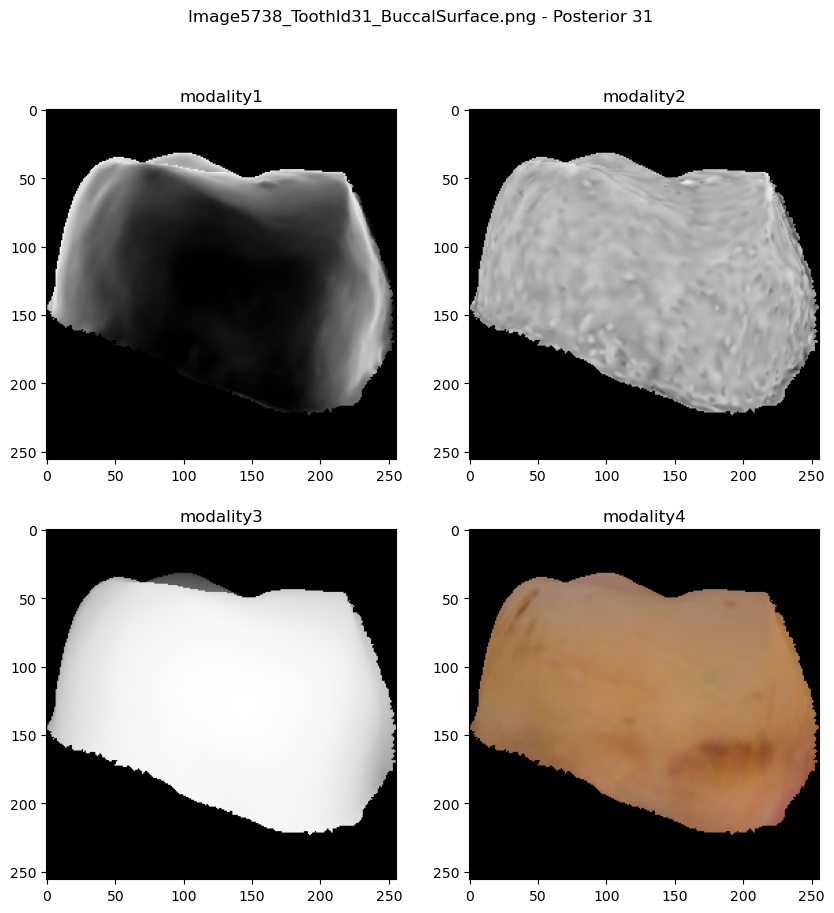

In [29]:
#for filename in list_sample_names[40:60]:
for filename in random.sample(list_sample_names, 10):
    
    list_numbers=[int(s) for s in re.findall(r'[\d]+', filename)]
    toothID=list_numbers[1]
    target=(toothID in range(6,12))|(toothID in range(22,28))
    target_description = 'Anterior' if target == 1 else 'Posterior'
    #print(toothID, target)
    #print(filename, list_numbers)
    
    filename_modality1=str("technical_challenge_data/modality1/"+filename)
    filename_modality2=str("technical_challenge_data/modality2/"+filename)
    filename_modality3=str("technical_challenge_data/modality3/"+filename)
    filename_modality4=str("technical_challenge_data/modality4/"+filename)
    
    img1 = io.imread(filename_modality1)
    img2 = io.imread(filename_modality2)
    img3 = io.imread(filename_modality3)
    img4 = io.imread(filename_modality4)
    
    fig, ax = plt.subplot_mosaic([['img1', 'img2'],['img3', 'img4']], figsize=(10,10))
    
    ax['img1'].imshow(img1, cmap=plt.cm.Greys_r)
    
    im = ax['img2'].imshow(img2, cmap=plt.cm.Greys_r)
    im = ax['img3'].imshow(img3, cmap=plt.cm.Greys_r)
    im = ax['img4'].imshow(img4)

    ax['img1'].set_title('modality1')
    ax['img2'].set_title('modality2')
    ax['img3'].set_title('modality3')
    ax['img4'].set_title('modality4')

    #fig.suptitle(filename)
    fig.suptitle(filename+" - "+str(target_description)+" "+str(toothID))
    plt.show()

In [41]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,6)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)),
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile(tf.keras.optimizers.Adam(
    learning_rate=0.001), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      880       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [44]:
logdir='logs'

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [46]:
tensorboard_callback

In [36]:
list_train_tensors=[]
list_train_target=[]

for item in tqdm(list(zip(X_train['Sample'], y_train))):
    
    filename=item[0]
    target=item[1]
    
    filename_modality1=str("technical_challenge_data/modality1/"+filename)
    filename_modality2=str("technical_challenge_data/modality2/"+filename)
    filename_modality3=str("technical_challenge_data/modality3/"+filename)
    filename_modality4=str("technical_challenge_data/modality4/"+filename)
    
    img1 = cv2.imread(filename_modality1, 0)
    img2 = cv2.imread(filename_modality2, 0)
    img3 = cv2.imread(filename_modality3, 0)
    img4 = cv2.imread(filename_modality4)
    
    
    #display(tf.concat([tf.concat([tf.concat([np.expand_dims(img1, axis=-1), np.expand_dims(img2, axis=-1)], -1),np.expand_dims(img3, axis=-1)], -1),img4], -1))
    list_train_tensors.append(tf.concat([tf.concat([tf.concat([np.expand_dims(img1, axis=-1), np.expand_dims(img2, axis=-1)], -1),np.expand_dims(img3, axis=-1)], -1),img4], -1))
    list_train_target.append(target)

100%|████████████████████████████████████████████████████████████████████████████| 24313/24313 [04:21<00:00, 92.80it/s]


In [37]:
list_valid_tensors=[]
list_valid_target=[]

for item in tqdm(list(zip(X_val['Sample'], y_val))):
    
    filename=item[0]
    target=item[1]
    
    filename_modality1=str("technical_challenge_data/modality1/"+filename)
    filename_modality2=str("technical_challenge_data/modality2/"+filename)
    filename_modality3=str("technical_challenge_data/modality3/"+filename)
    filename_modality4=str("technical_challenge_data/modality4/"+filename)
    
    img1 = cv2.imread(filename_modality1, 0)
    img2 = cv2.imread(filename_modality2, 0)
    img3 = cv2.imread(filename_modality3, 0)
    img4 = cv2.imread(filename_modality4)
    
    
    #display(tf.concat([tf.concat([tf.concat([np.expand_dims(img1, axis=-1), np.expand_dims(img2, axis=-1)], -1),np.expand_dims(img3, axis=-1)], -1),img4], -1))
    list_valid_tensors.append(tf.concat([tf.concat([tf.concat([np.expand_dims(img1, axis=-1), np.expand_dims(img2, axis=-1)], -1),np.expand_dims(img3, axis=-1)], -1),img4], -1))
    list_valid_target.append(target)

100%|██████████████████████████████████████████████████████████████████████████████| 7815/7815 [01:18<00:00, 99.97it/s]


In [38]:
list_train_tensors_new=np.asarray(list_train_tensors)
list_train_target_new=np.asarray(list_train_target)

In [39]:
list_valid_tensors_new=np.asarray(list_valid_tensors)
list_valid_target_new=np.asarray(list_valid_target)

In [47]:
callbacks = [
  # Остановить обучение если `val_loss` перестанет улучшаться в течение 2 эпох
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  # Записать логи TensorBoard в каталог `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

history = model.fit(list_train_tensors_new, list_train_target_new, batch_size=30, epochs=20, callbacks=callbacks, validation_data=(list_valid_tensors_new,list_valid_target_new))

Epoch 1/20
811/811 [==============================] - 128s 155ms/step - loss: 0.8123 - accuracy: 0.8817 - val_loss: 0.2118 - val_accuracy: 0.9138
Epoch 2/20
811/811 [==============================] - 116s 143ms/step - loss: 0.1862 - accuracy: 0.9260 - val_loss: 0.1751 - val_accuracy: 0.9317
Epoch 3/20
811/811 [==============================] - 114s 141ms/step - loss: 0.1445 - accuracy: 0.9420 - val_loss: 0.1639 - val_accuracy: 0.9378
Epoch 4/20
811/811 [==============================] - 115s 142ms/step - loss: 0.1056 - accuracy: 0.9606 - val_loss: 0.1584 - val_accuracy: 0.9417
Epoch 5/20
811/811 [==============================] - 115s 141ms/step - loss: 0.0857 - accuracy: 0.9674 - val_loss: 0.1890 - val_accuracy: 0.9409
Epoch 6/20
811/811 [==============================] - 115s 142ms/step - loss: 0.0755 - accuracy: 0.9712 - val_loss: 0.2245 - val_accuracy: 0.9381


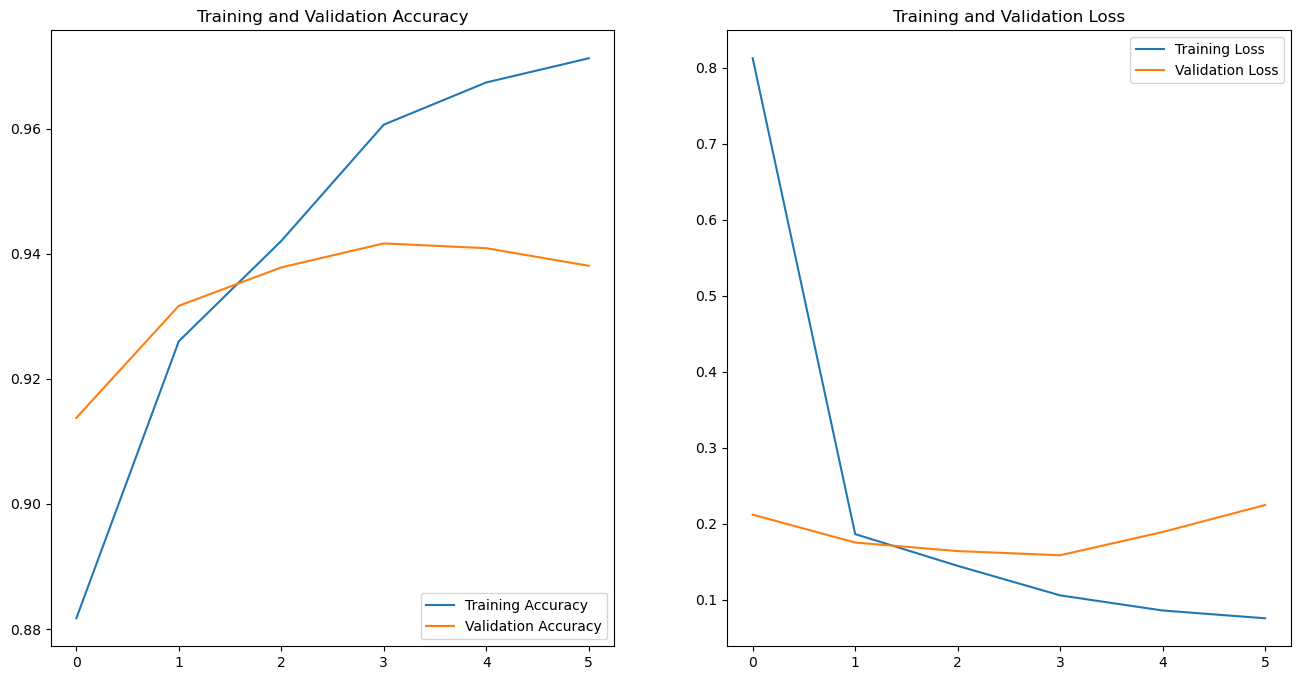

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
list_test_tensors=[]
list_test_target=[]

for item in tqdm(list(zip(X_test['Sample'], y_test))):
    
    filename=item[0]
    target=item[1]
    
    filename_modality1=str("technical_challenge_data/modality1/"+filename)
    filename_modality2=str("technical_challenge_data/modality2/"+filename)
    filename_modality3=str("technical_challenge_data/modality3/"+filename)
    filename_modality4=str("technical_challenge_data/modality4/"+filename)
    
    img1 = cv2.imread(filename_modality1, 0)
    img2 = cv2.imread(filename_modality2, 0)
    img3 = cv2.imread(filename_modality3, 0)
    img4 = cv2.imread(filename_modality4)
    
    
    #display(tf.concat([tf.concat([tf.concat([np.expand_dims(img1, axis=-1), np.expand_dims(img2, axis=-1)], -1),np.expand_dims(img3, axis=-1)], -1),img4], -1))
    list_test_tensors.append(tf.concat([tf.concat([tf.concat([np.expand_dims(img1, axis=-1), np.expand_dims(img2, axis=-1)], -1),np.expand_dims(img3, axis=-1)], -1),img4], -1))
    list_test_target.append(target)

100%|██████████████████████████████████████████████████████████████████████████████| 2606/2606 [01:11<00:00, 36.34it/s]


In [51]:
list_test_tensors_new=np.asarray(list_test_tensors)
list_test_target_new=np.asarray(list_test_target)

In [52]:
test_loss, test_acc = model.evaluate(list_test_tensors_new,  list_test_target_new, verbose=2)

82/82 - 3s - loss: 0.2353 - accuracy: 0.9382 - 3s/epoch - 37ms/step


In [53]:
predictions = model.predict(list_test_tensors_new)
predicted_probabilities=predictions.round(3).T[0]

82/82 [==============================] - 4s 35ms/step


In [54]:
predicted_probabilities

array([0.047, 1.   , 0.   , ..., 0.948, 0.003, 0.006], dtype=float32)

In [55]:
predicted_target = [int(i >= 0.5) for i in predicted_probabilities]

In [56]:
actual_target=list_test_target_new

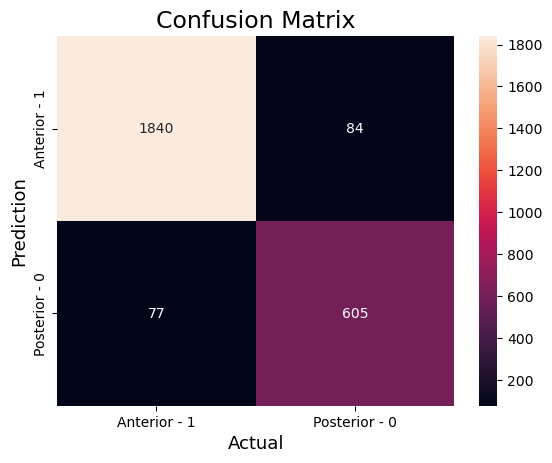

In [57]:
cm = confusion_matrix(actual_target,predicted_target)

sns.heatmap(cm, 
        annot=True,
        fmt='g', 
        xticklabels=['Anterior - 1','Posterior - 0'],
        yticklabels=['Anterior - 1','Posterior - 0'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [58]:
print(classification_report(actual_target,predicted_target))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1924
           1       0.88      0.89      0.88       682

    accuracy                           0.94      2606
   macro avg       0.92      0.92      0.92      2606
weighted avg       0.94      0.94      0.94      2606

